# Recommendation Systems

### Getting MovieLens data

* Download the movielens 100k dataset from this link: [ml-100k.zip](http://files.grouplens.org/datasets/movielens/ml-100k.zip)

* Upload ml-100k.zip

* Extract using the following cell:

### Imports

In [0]:
# import required libraries
!pip install wget
import os
import os.path
import numpy as np
import pandas as pd
from math import sqrt
from heapq import nlargest
from tqdm import trange
from tqdm import tqdm
from scipy import stats
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import mean_squared_error
import wget
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9681 sha256=f3f2ea9b1a8ea957314c22dfb8b1e6b543b7441411866e0697d00bc3116aea6f
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


## Support functions and variables

In [0]:
wget.download("https://github.com/MIE451-1513-2019/course-datasets/raw/master/ml-100k.zip")
!unzip ml-100k.zip
MOVIELENS_DIR = "ml-100k"

Archive:  ml-100k.zip
   creating: ml-100k/
  inflating: ml-100k/allbut.pl       
  inflating: ml-100k/mku.sh          
  inflating: ml-100k/README          
  inflating: ml-100k/u.data          
  inflating: ml-100k/u.genre         
  inflating: ml-100k/u.info          
  inflating: ml-100k/u.item          
  inflating: ml-100k/u.occupation    
  inflating: ml-100k/u.user          
  inflating: ml-100k/u1.base         
  inflating: ml-100k/u1.test         
  inflating: ml-100k/u2.base         
  inflating: ml-100k/u2.test         
  inflating: ml-100k/u3.base         
  inflating: ml-100k/u3.test         
  inflating: ml-100k/u4.base         
  inflating: ml-100k/u4.test         
  inflating: ml-100k/u5.base         
  inflating: ml-100k/u5.test         
  inflating: ml-100k/ua.base         
  inflating: ml-100k/ua.test         
  inflating: ml-100k/ub.base         
  inflating: ml-100k/ub.test         


In [0]:
!ls {MOVIELENS_DIR}

allbut.pl  u1.base  u2.test  u4.base  u5.test  ub.base	u.genre  u.occupation
mku.sh	   u1.test  u3.base  u4.test  ua.base  ub.test	u.info	 u.user
README	   u2.base  u3.test  u5.base  ua.test  u.data	u.item


In [0]:
def getData(folder_path, file_name):
    fields = ['userID', 'itemID', 'rating', 'timestamp']
    data = pd.read_csv(os.path.join(folder_path, file_name), sep='\t', names=fields)
    return data 

In [0]:
rating_df = getData(MOVIELENS_DIR, 'u.data')

In [0]:
rating_df.head()

,userID,itemID,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [0]:
num_users = len(rating_df.userID.unique())
num_items = len(rating_df.itemID.unique())
print("Number of users:", num_users)
print("Number of items:", num_items)

Number of users: 943
Number of items: 1682


### Data Preprocessing and Baseline algorithms

### (a) Produce a user-item matrix

In [0]:
def dataPreprocessor(rating_df, num_users, num_items):
    """
        INPUT: 
            data: pandas DataFrame. columns=['userID', 'itemID', 'rating' ...]
            num_row: int. number of users
            num_col: int. number of items
            
        OUTPUT:
            matrix: 2D numpy array. 
            
        NOTE 1: see where something very similar is done in the lab in function 'buildUserItemMatrix'    
            
        NOTE 2: data can have more columns, but your function should ignore 
              additional columns.
    """
    # Initialize a of size (numUsers, numItems) to zeros
    matrix = np.zeros((num_users, num_items), dtype=np.int8)
    
    # Populate the matrix based on the dataset
    for (index, userID, itemID, rating, timestamp) in rating_df.itertuples():
        matrix[userID-1, itemID-1] = rating
    
    return matrix

In [0]:
dataPreprocessor(rating_df, num_users, num_items)
#dimension: 943 * 1682

array([[5, 3, 4, ..., 0, 0, 0],
       [4, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [5, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 5, 0, ..., 0, 0, 0]], dtype=int8)

### (b) implement the two baseline algorithms: popularity and user average rating

In [0]:
class BaseLineRecSys(object):
    def __init__(self, method, processor=dataPreprocessor):
        """
            method: string. From ['popularity','useraverage']
            processor: function name. dataPreprocessor by default
        """
        self.method_name = method
        self.method = self._getMethod(self.method_name)
        self.processor = processor
        self.pred_column_name = self.method_name
        
    def _getMethod(self, method_name):
        """
            Don't change this
        """
        switcher = {
            'popularity': self.popularity,
            'useraverage': self.useraverage,
        }
        
        return switcher[method_name]
    
    @staticmethod
    def useraverage(train_matrix, num_users, num_items):
        """
            INPUT:
                train_matrix: 2D numpy array.
                num_users: int. Number of Users.
                num_items: int. Number of Items.
            OUTPUT:
                predictionMatrix: 2D numpy array.
                
            NOTE: see where something very similar is done in the lab in function 'predictByUserAverage'    
        """
        
        predictionMatrix = np.zeros((num_users, num_items))
        
        # Initialize the predicted rating matrix with zeros
        for (user,item), rating in np.ndenumerate(train_matrix):
        # Predict rating for every item 
            # Extract the items the user already rated
            userVector = train_matrix[user, :]
            # Extract the items the user already rated
            ratedItems = userVector[userVector.nonzero()]
            
            # If not empty, calculate average and set as rating for the current item
            if ratedItems.size == 0:
                itemAvg = 0
            else:
                itemAvg = ratedItems.mean()
                predictionMatrix[user, item] = itemAvg

        
        return predictionMatrix
    
    @staticmethod
    def popularity(train_matrix, num_users, num_items):
        """
            INPUT:
                train_matrix: 2D numpy array.
                num_users: int. Number of Users.
                num_items: int. Number of Items.
            OUTPUT:
                predictionMatrix: 2D numpy array.
                
            NOTE: see where something very similar is done in the lab in function 'predictByPopularity'    
        """
        
        predictionMatrix = np.zeros((num_users, num_items))
        
        # Define function for converting 1-5 rating to 0/1 (like / don't like)
        vf = np.vectorize(lambda x: 1 if x >= 4 else 0)
    
        # For every item calculate the number of people liked (4-5) divided by the number of people that rated
        itemPopularity = np.zeros((num_items))
        for item in range(num_items):
            numOfUsersRated = len(train_matrix[:, item].nonzero()[0])
            numOfUsersLiked = len(vf(train_matrix[:, item]).nonzero()[0])
            if numOfUsersRated == 0:
                itemPopularity[item] = 0
            else:
                itemPopularity[item] = numOfUsersLiked/numOfUsersRated
        # Predict rating for every item for the user
        for (user,item), rating in np.ndenumerate(train_matrix):
            predictionMatrix[user, item] = itemPopularity[item]

                
        
        return predictionMatrix    
    
    def predict_all(self, train_df, num_users, num_items):
        
        train_matrix = self.processor(train_df, num_users, num_items)
        self.__model = self.method(train_matrix, num_users, num_items)
        
    def evaluate_test(self, test_df, copy=False):
        
        if copy:
            prediction = test_df.copy()
        else:
            prediction = test_df
            
        prediction[self.pred_column_name] = np.nan
        
        for (index, 
             userID, 
             itemID) in tqdm(prediction[['userID','itemID']].itertuples()):
            prediction.loc[index, self.pred_column_name] = self.__model[userID-1, itemID-1]

        return prediction
        
    def getModel(self):
        """
            return predicted user-item matrix
        """
        return self.__model
    
    def getPredColName(self):
        """
            return prediction column name
        """
        return self.pred_column_name
    
    def reset(self):
        """
            reuse the instance of the class by removing model
        """
        try:
            self.model = None
        except:
            print("You don not have model..")
            

In [0]:
popularity_recsys = BaseLineRecSys('popularity')

In [0]:
popularity_recsys.predict_all(rating_df, num_users, num_items)

In [0]:
x = popularity_recsys.getModel()

array([[0.71017699, 0.38931298, 0.37777778, ..., 0.        , 0.        ,
        0.        ],
       [0.71017699, 0.38931298, 0.37777778, ..., 0.        , 0.        ,
        0.        ],
       [0.71017699, 0.38931298, 0.37777778, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.71017699, 0.38931298, 0.37777778, ..., 0.        , 0.        ,
        0.        ],
       [0.71017699, 0.38931298, 0.37777778, ..., 0.        , 0.        ,
        0.        ],
       [0.71017699, 0.38931298, 0.37777778, ..., 0.        , 0.        ,
        0.        ]])

In [0]:
np.all(x<=1)

True

In [0]:
rating_df.head()

,userID,itemID,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [0]:
popularity_recsys.evaluate_test(rating_df,copy=True).head()

100000it [01:23, 1200.96it/s]


,userID,itemID,rating,timestamp,popularity
0,196,242,3,881250949,0.760684
1,186,302,3,891717742,0.804714
2,22,377,1,878887116,0.076923
3,244,51,2,880606923,0.555556
4,166,346,1,886397596,0.611111


In [0]:
average_user_rating_recsys = BaseLineRecSys('useraverage')

In [0]:
average_user_rating_recsys.predict_all(rating_df, num_users, num_items)

In [0]:
average_user_rating_recsys.getModel()

array([[3.61029412, 3.61029412, 3.61029412, ..., 3.61029412, 3.61029412,
        3.61029412],
       [3.70967742, 3.70967742, 3.70967742, ..., 3.70967742, 3.70967742,
        3.70967742],
       [2.7962963 , 2.7962963 , 2.7962963 , ..., 2.7962963 , 2.7962963 ,
        2.7962963 ],
       ...,
       [4.04545455, 4.04545455, 4.04545455, ..., 4.04545455, 4.04545455,
        4.04545455],
       [4.26582278, 4.26582278, 4.26582278, ..., 4.26582278, 4.26582278,
        4.26582278],
       [3.41071429, 3.41071429, 3.41071429, ..., 3.41071429, 3.41071429,
        3.41071429]])

In [0]:
average_user_rating_recsys.evaluate_test(rating_df,copy=True).head()

100000it [01:26, 1159.11it/s]


,userID,itemID,rating,timestamp,useraverage
0,196,242,3,881250949,3.615385
1,186,302,3,891717742,3.413043
2,22,377,1,878887116,3.351562
3,244,51,2,880606923,3.651261
4,166,346,1,886397596,3.550000


## Similarity in Collaborative Filtering

### (a) Cosine, Euclidean and Manhattan distance metrics

In [0]:
class SimBasedRecSys(object):

    def __init__(self, base, method, processor=dataPreprocessor):
        """
            base: string. From ['user', 'item']. User-based Similarity or Item-based
            method: string. From ['cosine', 'euclidean', 'somethingelse']
            processor: function name. dataPreprocessor by default
        """
        self.base = base
        self.method_name = method
        self.method = self._getMethod(self.method_name)
        self.processor = processor
        self.pred_column_name = self.base+'-'+self.method_name
    
    def _getMethod(self, method_name):
        """
            Don't change this
        """
        switcher = {
            'cosine': self.cosine,
            'euclidean': self.euclidean,
            'somethingelse': self.somethingelse,
        }
        
        return switcher[method_name]
    
    @staticmethod
    def cosine(matrix):
        """
            cosine similarity
        """
        similarity_matrix = 1 - pairwise_distances(matrix, metric='cosine')
        return similarity_matrix
    
    @staticmethod
    def euclidean(matrix):
        """
            euclidean similarity
        """
        

        similarity_matrix = 1 / (1 + pairwise_distances(matrix, metric = 'euclidean'))
    
            
        
        return similarity_matrix
    
    @staticmethod
    def somethingelse(matrix):
        """
            manhattan? or super-natural intuition similarity
        """
        
        
        similarity_matrix = 1 / (1 + pairwise_distances(matrix, metric = 'manhattan'))
    
               
        return similarity_matrix
        
    def predict_all(self, train_df, num_users, num_items):
        """
            INPUT: 
                data: pandas DataFrame. columns=['userID', 'itemID', 'rating'...]
                num_row: scalar. number of users
                num_col: scalar. number of items
            OUTPUT:
                no return... this method assigns the result to self.model
            
            NOTES:
                self.__model should contain predictions for *all* user and items
                (don't worry about predicting for observed (user,item) pairs,
                 since we won't be using these predictions in the evaluation)
                (see code in for an efficient vectorized example)
        """
        train_matrix = self.processor(train_df, num_users, num_items)
        
        if self.base == 'user':
            
            # Initialize the predicted rating matrix with zeros
            temp_matrix = np.zeros(train_matrix.shape)
            temp_matrix[train_matrix.nonzero()] = 1
            uu_similarity = self.method(train_matrix)
            # UxI: UxU mul UxI
            normalizer = np.matmul(uu_similarity, temp_matrix)
            #print(normalizer)
            normalizer[normalizer == 0] = 1e-5
            #what's the dimension of np.matmul(uu_similarity, trainSet)
    
            predictionMatrix = np.matmul(uu_similarity, train_matrix)/normalizer #dimension: U X I
            #predictionMatrix[temp_matrix.nonzero()] = 0
             
            useraverage = np.sum(train_matrix, axis=1)/(np.sum(temp_matrix, axis=1)+1e-5)
            columns = np.sum(predictionMatrix, axis=0)
            #print(columns.shape)
            predictionMatrix[:, columns==0] = predictionMatrix[:, columns==0] + np.expand_dims(useraverage, axis=1)
            self.__model = predictionMatrix
            
            
        elif self.base == 'item':
            
            train_matrix = train_matrix.T
            temp_matrix = np.zeros(train_matrix.shape)
            temp_matrix[train_matrix.nonzero()] = 1
            ii_similarity = self.method(train_matrix)
            # UxI: UxU mul UxI
            normalizer = np.matmul(ii_similarity, temp_matrix)
            #print(normalizer)
            normalizer[normalizer == 0] = 1e-5
            #what's the dimension of np.matmul(uu_similarity, trainSet)
    
            predictionMatrix = np.matmul(ii_similarity, train_matrix)/normalizer #dimension: U X I
            #predictionMatrix[temp_matrix.nonzero()] = 0
             
            itemaverage = np.sum(train_matrix, axis=1)/(np.sum(temp_matrix, axis=1)+1e-5)
            columns = np.sum(predictionMatrix, axis=0)
            #print(columns.shape)
            predictionMatrix[:, columns==0] = predictionMatrix[:, columns==0] + np.expand_dims(itemaverage, axis=1)
            self.__model = predictionMatrix.T
            
        else:
            print('No other option available')
        
    def evaluate_test(self, test_df, copy=False):
        """
            INPUT:
                data: pandas DataFrame. columns=['userID', 'itemID', 'rating'...]
            OUTPUT:
                predictions:  pandas DataFrame. 
                              columns=['userID', 'itemID', 'rating', 'base-method'...]
                              
            NOTE: 1. data can have more columns, but your function should ignore 
                  additional columns.
                  2. 'base-method' depends on your 'base' and 'method'. For example,
                  if base == 'user' and method == 'cosine', 
                  then base-method == 'user-cosine'
                  3. your predictions go to 'base-method' column
        """
        if copy:
            prediction = test_df.copy()
        else:
            prediction = test_df
        prediction[self.pred_column_name] = np.nan
        
        for (index, 
             userID, 
             itemID) in tqdm(prediction[['userID','itemID']].itertuples()):
            prediction.loc[index, self.pred_column_name] = self.__model[userID-1, itemID-1]
    
        return prediction
    
    def getModel(self):
        """
            return predicted user-item matrix
        """
        return self.__model
    
    def getPredColName(self):
        """
            return prediction column name
        """
        return self.pred_column_name
    
    def reset(self):
        """
            reuse the instance of the class by removing model
        """
        try:
            self.model = None
        except:
            print("You do not have model..")

Cosine metric works better. Euclidean distance measures the distance between two end points of vector, which is largely affected by the magnitude of the vectors.Cosine measures the angle between two vectors.


In [0]:
# Examples of how to call similarity functions.
I = np.eye(3)
SimBasedRecSys.cosine(I)

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [0]:
SimBasedRecSys.euclidean(I)

array([[1.        , 0.41421356, 0.41421356],
       [0.41421356, 1.        , 0.41421356],
       [0.41421356, 0.41421356, 1.        ]])

In [0]:
SimBasedRecSys.somethingelse(I)

array([[1.        , 0.33333333, 0.33333333],
       [0.33333333, 1.        , 0.33333333],
       [0.33333333, 0.33333333, 1.        ]])

Manhattan distance defines the similarity measure as the distance along the scale of each variable and is preferable for high dimension data which is not comparable from each other.

## Collaborative Filtering

### (a) implement user-user and item-item based collaborative ltering algorithms

In [0]:
user_cosine_recsys = SimBasedRecSys('user','cosine')

In [0]:
user_cosine_recsys.predict_all(rating_df, num_users, num_items)

In [0]:
user_cosine_recsys.getModel()
#shape:943*1682

In [0]:
rating_df.head()

,userID,itemID,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [0]:
user_cosine_recsys.evaluate_test(rating_df,copy=True).head()


0it [00:00, ?it/s]
104it [00:00, 1039.55it/s]
208it [00:00, 1037.32it/s]
314it [00:00, 1044.02it/s]
422it [00:00, 1054.41it/s]
529it [00:00, 1056.50it/s]
634it [00:00, 1051.30it/s]
733it [00:00, 1029.32it/s]
839it [00:00, 1035.28it/s]
945it [00:00, 1042.16it/s]
1049it [00:01, 1040.77it/s]
1151it [00:01, 1022.76it/s]
1255it [00:01, 1026.90it/s]
1361it [00:01, 1033.56it/s]
1464it [00:01, 1023.14it/s]
1571it [00:01, 1034.31it/s]
1680it [00:01, 1049.63it/s]
1785it [00:01, 1045.29it/s]
1890it [00:01, 1041.15it/s]
1995it [00:01, 1033.43it/s]
2099it [00:02, 1031.81it/s]
2205it [00:02, 1037.51it/s]
2311it [00:02, 1044.10it/s]
2418it [00:02, 1049.65it/s]
2524it [00:02, 1051.54it/s]
2630it [00:02, 1044.49it/s]
2735it [00:02, 1039.68it/s]
2839it [00:02, 1027.64it/s]
2942it [00:02, 1013.92it/s]
3044it [00:02, 987.34it/s] 
3143it [00:03, 972.90it/s]
3247it [00:03, 990.26it/s]
3347it [00:03, 992.77it/s]
3453it [00:03, 1009.90it/s]
3555it [00:03, 1007.37it/s]
3658it [00:03, 1013.91it/s]
3761it [00:0

,userID,itemID,rating,timestamp,user-cosine
0,196,242,3,881250949,4.025213
1,186,302,3,891717742,4.142828
2,22,377,1,878887116,1.922080
3,244,51,2,880606923,3.431884
4,166,346,1,886397596,3.424963


In [0]:
item_cosine_recsys = SimBasedRecSys('item','cosine')
item_cosine_recsys.predict_all(rating_df, num_users, num_items)
item_cosine_recsys.getModel()
item_cosine_recsys.evaluate_test(rating_df,copy=True).head()

100000it [01:26, 1160.50it/s]


,userID,itemID,rating,timestamp,item-cosine
0,196,242,3,881250949,3.591314
1,186,302,3,891717742,3.344077
2,22,377,1,878887116,2.965365
3,244,51,2,880606923,3.637332
4,166,346,1,886397596,3.333013


### (b) Calculate RMSE using Cross Validation

In [0]:
class CrossValidation(object):
    def __init__(self, metric, data_path=MOVIELENS_DIR):
        """
            INPUT:
                metric: string. from['RMSE','P@K','R@K']
        """
        self.folds = self._getData(MOVIELENS_DIR)
        self.metric_name = metric
        self.metric = self._getMetric(self.metric_name)
        
    def _getMetric(self, metric_name):
        """
            Don't change this
        """
        switcher = {
            'RMSE': self.rmse,
            'P@K': self.patk,
            'R@K': self.ratk,
        }
        
        return switcher[metric_name]
    
    @staticmethod
    def rmse(data, k, num_users, num_items, pred, true='rating'):
        """
            data: pandas DataFrame. 
            pred: string. Column name that corresponding to the prediction
            true: string. Column name that corresponding to the true rating
        """
        return sqrt(mean_squared_error(data[pred], data[true]))
    
    # Precision at k
    def patk(self, data, k, num_users, num_items, pred, true='rating'):
        """
            data: pandas DataFrame. 
            k: top-k items retrived
            pred: string. Column name that corresponding to the prediction
            true: string. Column name that corresponding to the true rating
        """
        prediction = self.getMatrix(data, num_users, num_items, pred)
        testSet =  self.getMatrix(data, num_users, num_items, true)
    
        # Initialize sum and count vars for average calculation
        sumPrecisions = 0
        countPrecisions = 0

        # Define function for converting 1-5 rating to 0/1 (like / don't like)
        vf = np.vectorize(lambda x: 1 if x >= 4 else 0)

        for userID in range(num_users):
            # Pick top K based on predicted rating
            userVector = prediction[userID,:]
            topK = nlargest(k, range(len(userVector)), userVector.take)

            # Convert test set ratings to like / don't like
            userTestVector = vf(testSet[userID,:]).nonzero()[0]

            # Calculate precision
            precision = float(len([item for item in topK if item in userTestVector]))/len(topK)

            # Update sum and count
            sumPrecisions += precision
            countPrecisions += 1

        # Return average P@k
        return float(sumPrecisions)/countPrecisions
    
    # Recall at k
    def ratk(self, data, k, num_users, num_items, pred, true='rating'):
        """
            data: pandas DataFrame. 
            k: top-k items relevant
            pred: string. Column name that corresponding to the prediction
            true: string. Column name that corresponding to the true rating
        """
        prediction = self.getMatrix(data, num_users, num_items, pred)
        testSet =  self.getMatrix(data, num_users, num_items, true)
        # Initialize sum and count vars for average calculation
        sumRecalls = 0
        countRecalls = 0

        # Define function for converting 1-5 rating to 0/1 (like / don't like)
        vf = np.vectorize(lambda x: 1 if x >= 4 else 0)

        for userID in range(num_users):
            # Pick top K based on predicted rating
            userVector = prediction[userID,:]
            topK = nlargest(k, range(len(userVector)), userVector.take)

            # Convert test set ratings to like / don't like
            userTestVector = vf(testSet[userID,:]).nonzero()[0]

            # Ignore user if has no ratings in the test set
            if (len(userTestVector) == 0):
                continue

            # Calculate recall
            recall = float(len([item for item in topK if item in userTestVector]))/len(userTestVector)

            # Update sum and count
            sumRecalls += recall
            countRecalls += 1

        # Return average R@k
        return float(sumRecalls)/countRecalls
    
    @staticmethod
    def getMatrix(rating_df, num_users, num_items, column_name):
        matrix = np.zeros((num_users, num_items))
    
        for (index, userID, itemID, value) in rating_df[['userID','itemID', column_name]].itertuples():
            matrix[userID-1, itemID-1] = value
            
        return matrix
    
    @staticmethod
    def _getData(data_path):
        """
            Don't change this function
        """
        folds = []
        data_types = ['u{0}.base','u{0}.test']
        for i in range(1,6):
            train_set = getData(data_path, data_types[0].format(i))
            test_set = getData(data_path, data_types[1].format(i))
            folds.append([train_set, test_set])
        return folds
    
    def run(self, algorithms, num_users, num_items, k=1):
        """
            5-fold cross-validation
            algorithms: list. a list of algorithms. 
                        eg: [user_cosine_recsys, item_euclidean_recsys]
        """
        
        scores = {}
        for algorithm in algorithms:
            print('Processing algorithm {0}'.format(algorithm.getPredColName()))
            fold_scores = []
            for fold in self.folds:
                algorithm.reset()
                algorithm.predict_all(fold[0], num_users, num_items)
                prediction = algorithm.evaluate_test(fold[1])
                pred_col = algorithm.getPredColName()
                fold_scores.append(self.metric(prediction, k, num_users, num_items, pred_col))
                
            mean = np.mean(fold_scores)
            ci_low, ci_high = stats.t.interval(0.95, len(fold_scores)-1, loc=mean, scale=stats.sem(fold_scores))
            scores[algorithm.getPredColName()] = [fold_scores, mean, ci_low, ci_high]
            
        results = scores    
    
        return results
            

In [0]:
# How to use CrossValidation Class?

In [0]:
# 1. gather your algorithms in previous steps.
algorithm_instances = [user_cosine_recsys,
                       item_cosine_recsys]

In [0]:
# 2. Instantiate a CrossValidation instance and assign the measurement that you want to use
# RMSE, P@K, R@K
# Precision at K in this example
cv_rmse = CrossValidation('RMSE')

In [0]:
# 3. Run CV by giving:
#    1> algorithms just gathered
#    2> number of users in the full dataset
#    3> number of items in the full dataset
#    4> precision or recall at K need a K value, so k=5 means precision at 5 in this example
# Results include independent results from 5 folds, their mean, and confidence interval.
cv_rmse.run(algorithm_instances, num_users, num_items,k=5)

Processing algorithm user-cosine


20000it [00:09, 2121.72it/s]
20000it [00:09, 2140.61it/s]
20000it [00:09, 2147.82it/s]
20000it [00:09, 2145.95it/s]
20000it [00:09, 2137.60it/s]


Processing algorithm item-cosine


20000it [00:09, 2129.85it/s]
20000it [00:09, 2128.17it/s]
20000it [00:09, 2143.96it/s]
20000it [00:09, 2132.26it/s]
20000it [00:09, 2145.14it/s]


{'item-cosine': [[1.0377631264364244,
   1.0207280585350078,
   1.0101820660011798,
   1.0136832839209695,
   1.0180579656376574],
  1.020082900106248,
  1.0068242686250732,
  1.0333415315874226],
 'user-cosine': [[1.0264490128856898,
   1.0214387664092763,
   1.0132940323507253,
   1.009400399702741,
   1.0161883960008826],
  1.017354121469863,
  1.0090130800118484,
  1.0256951629278774]}

The user-cosine performs better than item-cosine with lower RMSE values bescause users have more rating data than items.The average number of ratings per user (more than 1600 movies) is much greater than the average number of ratings per item (more than 900 users).

## Probabilistic Matrix Factorization(PMF)

In [0]:
class PMFRecSys(object):
    def __init__(self, num_feat=10, epsilon=1, _lambda=0.1, momentum=0.8, maxepoch=20, num_batches=10, batch_size=1000):
        """
            num_feat: int, number of latent features
            epsilon: float, learning rate
            _lambda: float, L2 regularization,
            momentum: float, momentum of the gradient,
            maxepoch: float, Number of epoch before stop,
            num_batches: int, Number of batches in each epoch (for SGD optimization),
            batch_size:Number int, of training samples used in each batches (for SGD optimization)
            
        """
        self.num_feat = num_feat  # Number of latent features,
        self.epsilon = epsilon  # learning rate,
        self._lambda = _lambda  # L2 regularization,
        self.momentum = momentum  # momentum of the gradient,
        self.maxepoch = maxepoch  # Number of epoch before stop,
        self.num_batches = num_batches  # Number of batches in each epoch (for SGD optimization),
        self.batch_size = batch_size  # Number of training samples used in each batches (for SGD optimization)
        self.test = False
        self.w_Item = None  # Item feature vectors
        self.w_User = None  # User feature vectors
        
        self.rmse_train = []
        self.rmse_test = []
        self.pred_column_name='PMF'

    def predict_all(self, train_vec, num_user, num_item):
        """
            INPUT: 
                data: pandas DataFrame. columns=['userID', 'itemID', 'rating'...]
                num_user: scalar. number of users
                num_item: scalar. number of items
            OUTPUT:
                no return... this method update w_User and w_Item
            
            NOTES:
                self.W_Item and self.W_User are use to do the final predition for a user
                
        """
        # select 'userID', 'itemID', 'rating only
        train_vec = train_vec.iloc[:, :3].values
        if self.test:
          train_vec, val_vec = train_test_split(train_vec)
          pairs_val = val_vec.shape[0]
          self.mean_rating_test = np.mean(val_vec[:, 2])
        self.mean_rating_train = np.mean(train_vec[:, 2])  # avg rating
        pairs_train = train_vec.shape[0]  # num of rating
        

        # to avoid out of bound
        num_user += 1  
        num_item += 1  
        # initialize
        self.epoch = 0
        
        
        #borrow codes from https://github.com/fuhailin/Probabilistic-Matrix-Factorization
        
        self.w_Item = sqrt(0.1) * np.random.randn(num_item,self.num_feat)  # item M x D 
        self.w_User = sqrt(0.1) * np.random.randn(num_user,self.num_feat)  # user N x D 
    
        

        self.w_Item_inc = np.zeros((num_item, self.num_feat))  # accumulate the gradient
        self.w_User_inc = np.zeros((num_user, self.num_feat))  # accumulate the gradient
        while self.epoch < self.maxepoch: 
            self.epoch += 1

            # Shuffle training truples
            shuffled_order = np.arange(train_vec.shape[0])  
            np.random.shuffle(shuffled_order)  #shuffled

            # Batch update
            for batch in range(self.num_batches): 
                # print "epoch %d batch %d" % (self.epoch, batch+1)

                test = np.arange(self.batch_size * batch, self.batch_size * (batch + 1))
                batch_idx = np.mod(test, shuffled_order.shape[0])  # get the real data index


                batch_UserID = np.array(train_vec[shuffled_order[batch_idx], 0], dtype='int32')
                batch_ItemID = np.array(train_vec[shuffled_order[batch_idx], 1], dtype='int32')

                # Compute Compute mean rating subtracted rating  
                
                
                pred_out = np.sum(np.multiply(self.w_User[batch_UserID,:], self.w_Item[batch_ItemID,:]), 
                                  axis=1) #size (batch_size, )
            
            
              

                rawErr = pred_out + self.mean_rating_train - train_vec[shuffled_order[batch_idx], 2]

                # Compute gradients
                Ix_User = 2 * np.multiply(rawErr[:, np.newaxis], self.w_Item[batch_ItemID, :]) \
                       + self._lambda * self.w_User[batch_UserID, :]
                Ix_Item = 2 * np.multiply(rawErr[:, np.newaxis], self.w_User[batch_UserID, :]) \
                       + self._lambda * (self.w_Item[batch_ItemID, :])  # np.newaxis :increase the dimension

                dw_Item = np.zeros((num_item, self.num_feat))
                dw_User = np.zeros((num_user, self.num_feat))

                # loop to aggreate the gradients of the same element
                for i in range(self.batch_size):
                    dw_Item[batch_ItemID[i], :] += Ix_Item[i, :]
                    dw_User[batch_UserID[i], :] += Ix_User[i, :]

                # Update with momentum
                self.w_Item_inc = self.momentum * self.w_Item_inc + self.epsilon * dw_Item / self.batch_size
                self.w_User_inc = self.momentum * self.w_User_inc + self.epsilon * dw_User / self.batch_size

                self.w_Item = self.w_Item - self.w_Item_inc
                self.w_User = self.w_User - self.w_User_inc

                # Compute Compute mean rating subtracted rating 
                if batch == self.num_batches - 1:
                    train_user_idx = np.array(train_vec[:, 0], dtype='int32')
                    train_item_idx = np.array(train_vec[:, 1], dtype='int32')
                    
            
                    pred_out = np.sum(np.multiply(self.w_User[np.array(train_vec[:, 0], dtype='int32'), :],
                                                  self.w_Item[np.array(train_vec[:, 1], dtype='int32'), :]),
                                      axis=1)# size(pairs_train, )
            
            
                    
                    rawErr = pred_out + self.mean_rating_train - train_vec[:, 2] 
                    obj = np.linalg.norm(rawErr) ** 2 \
                          + 0.5 * self._lambda * (np.linalg.norm(self.w_User) ** 2 + np.linalg.norm(self.w_Item) ** 2)

                    self.rmse_train.append(np.sqrt(obj / pairs_train))

                # Compute validation error
                if batch == self.num_batches - 1 and self.test:
                    val_user_idx = np.array(val_vec[:, 0], dtype='int32')
                    val_item_idx = np.array(val_vec[:, 1], dtype='int32')
                    
            
                    pred_out = np.sum(np.multiply(self.w_User[np.array(val_vec[:, 0], dtype='int32'), :],
                                                  self.w_Item[np.array(val_vec[:, 1], dtype='int32'), :]),
                                      axis=1) #size(pairs_val, )
            
            
                   
                    rawErr = pred_out + self.mean_rating_test - val_vec[:, 2]
                    self.rmse_test.append(np.linalg.norm(rawErr) / np.sqrt(pairs_val))


        

        
    def evaluate_test(self, test_df, copy=False):
        """
            INPUT:
                data: pandas DataFrame. columns=['userID', 'itemID', 'rating'...]
            OUTPUT:
                predictions:  pandas DataFrame. 
                              columns=['userID', 'itemID', 'rating', 'base-method'...]
                              
        """
        if copy:
            prediction = pd.DataFrame(test_df.copy(), columns=['userID', 'itemID', 'rating'])
        else:
            prediction = pd.DataFrame(test_df, columns=['userID', 'itemID', 'rating'])
        prediction[self.pred_column_name] = np.nan
        
        for (index, 
             userID, 
             itemID) in tqdm(prediction[['userID','itemID']].itertuples()):
            prediction.loc[index, self.pred_column_name] = (np.dot(self.w_Item, self.w_User[int(userID), :]) + self.mean_rating_train)[int(itemID)]
    
        return prediction
    
    def plot_error(self):
      if self.test:
        plt.plot(range(pmf.maxepoch), pmf.rmse_test, marker='v', label='Test Data')
      plt.plot(range(pmf.maxepoch), pmf.rmse_train, marker='o', label='Training Data')
      plt.title('The MovieLens Dataset Learning Curve')
      plt.xlabel('Number of Epochs')
      plt.ylabel('RMSE')
      plt.legend()
      plt.grid()
      plt.show()
          
    def getPredColName(self):
        """
            return prediction column name
        """
        return self.pred_column_name
    
    def reset(self):
        """
            reuse the instance of the class by removing model
        """
        try:
            self.w_Item = None 
            self.w_User = None 
        except:
            print("You do not have w_Item, w_User")

    def set_params(self, parameters):
        if isinstance(parameters, dict):
            self.num_feat = parameters.get("num_feat", 10)
            self.epsilon = parameters.get("epsilon", 1)
            self._lambda = parameters.get("_lambda", 0.1)
            self.momentum = parameters.get("momentum", 0.8)
            self.maxepoch = parameters.get("maxepoch", 20)
            self.num_batches = parameters.get("num_batches", 10)
            self.batch_size = parameters.get("batch_size", 1000)
            self.test = parameters.get("test_mode", False)

In [0]:
pmf = PMFRecSys()
pmf.set_params({"num_feat": 10, "epsilon": 1, "_lambda": 0.1, "momentum": 0.8, "maxepoch": 15, "num_batches": 100,
                "batch_size": 1000, 'test_mode':False})

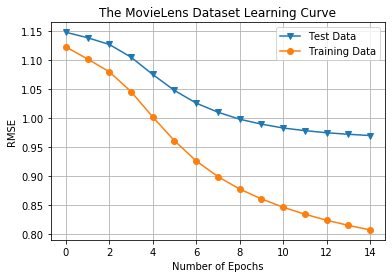

In [0]:
pmf.predict_all(rating_df, num_users, num_items)
pmf.plot_error()

Maxepoch = 15, because the slope of RMSE starts to decrease after this point.

## Performance Comparison

### Calculate RMSE, P@k, and R@k for all previous recommenders using Cross Validation

In [0]:
algorithm_instances = [popularity_recsys, 
                       average_user_rating_recsys, 
                       user_cosine_recsys,
                       item_cosine_recsys,
                       pmf]

In [0]:
cv_rmse = CrossValidation('RMSE')
cv_rmse.run(algorithm_instances, num_users, num_items,k=5)

Processing algorithm popularity


20000it [00:09, 2086.00it/s]
20000it [00:09, 2137.30it/s]
20000it [00:09, 2132.33it/s]
20000it [00:09, 2136.01it/s]
20000it [00:09, 2070.82it/s]


Processing algorithm useraverage


20000it [00:09, 2144.33it/s]
20000it [00:09, 2157.73it/s]
20000it [00:09, 2125.87it/s]
20000it [00:09, 2144.69it/s]
20000it [00:09, 2136.85it/s]


Processing algorithm user-cosine


20000it [00:09, 2125.13it/s]
20000it [00:09, 2145.50it/s]
20000it [00:09, 2154.56it/s]
20000it [00:09, 2129.52it/s]
20000it [00:09, 2122.74it/s]


Processing algorithm item-cosine


20000it [00:09, 2142.14it/s]
20000it [00:09, 2157.85it/s]
20000it [00:09, 2127.89it/s]
20000it [00:09, 2145.47it/s]
20000it [00:09, 2119.51it/s]


Processing algorithm PMF


20000it [00:16, 1198.68it/s]
20000it [00:16, 1184.93it/s]
20000it [00:16, 1206.89it/s]
20000it [00:16, 1209.41it/s]
20000it [00:16, 1192.26it/s]


{'PMF': [[0.9890461523121571,
   0.9600737125800379,
   0.9509643861141105,
   0.9550382459411881,
   0.9581241214762187],
  0.9626493236847425,
  0.9438352451892071,
  0.9814634021802779],
 'item-cosine': [[1.0377631264364244,
   1.0207280585350078,
   1.0101820660011798,
   1.0136832839209695,
   1.0180579656376574],
  1.020082900106248,
  1.0068242686250732,
  1.0333415315874226],
 'popularity': [[3.177941281084362,
   3.1750480150769977,
   3.147474655005899,
   3.146164503024159,
   3.1488360007536382],
  3.1590928909890112,
  3.139292746995387,
  3.1788930349826354],
 'user-cosine': [[1.0264490128856898,
   1.0214387664092763,
   1.0132940323507253,
   1.009400399702741,
   1.0161883960008826],
  1.017354121469863,
  1.0090130800118484,
  1.0256951629278774],
 'useraverage': [[1.0629951276561334,
   1.0467467492319966,
   1.0328964562995389,
   1.0366575971298078,
   1.0392923504800367],
  1.0437176561595025,
  1.0289303496379316,
  1.0585049626810734]}

In [0]:
cv_patk = CrossValidation('P@K')
cv_patk.run(algorithm_instances, num_users, num_items,k=5)

Processing algorithm popularity


20000it [00:09, 2112.38it/s]
20000it [00:09, 2139.38it/s]
20000it [00:09, 2152.11it/s]
20000it [00:09, 2140.92it/s]
20000it [00:09, 2129.70it/s]


Processing algorithm useraverage


20000it [00:09, 2125.82it/s]
20000it [00:09, 2124.66it/s]
20000it [00:09, 2122.05it/s]
20000it [00:09, 2110.98it/s]
20000it [00:09, 2146.08it/s]


Processing algorithm user-cosine


20000it [00:09, 2163.27it/s]
20000it [00:09, 2125.56it/s]
20000it [00:09, 2142.50it/s]
20000it [00:09, 2127.28it/s]
20000it [00:09, 2145.94it/s]


Processing algorithm item-cosine


20000it [00:09, 2159.24it/s]
20000it [00:09, 2144.93it/s]
20000it [00:09, 2144.38it/s]
20000it [00:09, 2132.28it/s]
20000it [00:09, 2125.43it/s]


Processing algorithm PMF


20000it [00:16, 1220.28it/s]
20000it [00:16, 1198.21it/s]
20000it [00:16, 1204.32it/s]
20000it [00:16, 1193.40it/s]
20000it [00:16, 1193.65it/s]


{'PMF': [[0.36139978791092336,
   0.49607635206786993,
   0.6154825026511149,
   0.6347826086956528,
   0.6176033934252393],
  0.5450689289501601,
  0.4002639539368521,
  0.6898739039634681],
 'item-cosine': [[0.34316012725344736,
   0.483563096500532,
   0.6021208907741271,
   0.6248144220572649,
   0.6074231177094392],
  0.5322163308589621,
  0.3837005215009889,
  0.6807321402169354],
 'popularity': [[0.36924708377518656,
   0.4965005302226948,
   0.6152704135737019,
   0.6426299045599162,
   0.6292682926829279],
  0.5505832449628855,
  0.40544114481568705,
  0.6957253451100839],
 'user-cosine': [[0.37179215270413657,
   0.503923647932133,
   0.621633085896077,
   0.6483563096500541,
   0.6335100742311777],
  0.5558430540827157,
  0.40959849499983714,
  0.7020876131655943],
 'useraverage': [[0.30604453870625714,
   0.4305408271474029,
   0.5321314952279973,
   0.5520678685047737,
   0.5474019088016986],
  0.4736373276776259,
  0.3419993013451059,
  0.6052753540101459]}

In [0]:
cv_ratk = CrossValidation('R@K')
cv_ratk.run(algorithm_instances, num_users, num_items,k=5)

Processing algorithm popularity


20000it [00:09, 2124.33it/s]
20000it [00:09, 2119.50it/s]
20000it [00:09, 2075.87it/s]
20000it [00:09, 2146.07it/s]
20000it [00:09, 2165.37it/s]


Processing algorithm useraverage


20000it [00:09, 2134.08it/s]
20000it [00:09, 2163.58it/s]
20000it [00:09, 2157.60it/s]
20000it [00:09, 2134.13it/s]
20000it [00:09, 2126.66it/s]


Processing algorithm user-cosine


20000it [00:09, 2110.99it/s]
20000it [00:09, 2139.06it/s]
20000it [00:09, 2114.24it/s]
20000it [00:09, 2128.47it/s]
20000it [00:09, 2109.47it/s]


Processing algorithm item-cosine


20000it [00:09, 2131.24it/s]
20000it [00:09, 2115.96it/s]
20000it [00:09, 2097.88it/s]
20000it [00:09, 2103.35it/s]
20000it [00:09, 2081.07it/s]


Processing algorithm PMF


20000it [00:16, 1205.97it/s]
20000it [00:16, 1199.50it/s]
20000it [00:16, 1207.80it/s]
20000it [00:16, 1208.08it/s]
20000it [00:16, 1208.55it/s]


{'PMF': [[0.3382943802019999,
   0.4280276278078083,
   0.5286933538865981,
   0.5440993633995626,
   0.5609326125352756],
  0.4800094675662489,
  0.36252372695497526,
  0.5974952081775226],
 'item-cosine': [[0.3277711938444533,
   0.4237782250680911,
   0.5191391022223312,
   0.5448659224612776,
   0.5593011306991799],
  0.4749711148590666,
  0.35357317503649865,
  0.5963690546816346],
 'popularity': [[0.3466588624187514,
   0.4274468698270901,
   0.5269205125667804,
   0.5518738761026849,
   0.5674793185065369],
  0.4840758878843688,
  0.3671373629798323,
  0.6010144127889052],
 'user-cosine': [[0.34778041993806913,
   0.4314035774468209,
   0.5293633772333985,
   0.5553818201403046,
   0.5674144230096255],
  0.4862687235536437,
  0.3694473610987218,
  0.6030900860085656],
 'useraverage': [[0.30505841002027845,
   0.39554692074366876,
   0.48030412192442223,
   0.5045885853815734,
   0.5211179870422066],
  0.44132320502242983,
  0.32931026359142457,
  0.5533361464534351]}

RMSE:

'PMF': 0.96 (0.94-0.98)

'item-cosine': 1.02 (1.01-1.03)

'popularity': 3.16 (3.14-3.18)

'user-cosine': 1.02 (1.01-1.03)

'useraverage': 1.04 (1.03-1.06)


P@k:

'PMF': 0.548 (0.40-0.69)

'item-cosine': 0.53 (0.38-0.68)

'popularity': 0.55 (0.41-0.70)

'user-cosine': 0.56 (0.41-0.70)

'useraverage': 0.47 (0.34-0.60)

R@k:

'PMF': 0.48 (0.36-0.60)

'item-cosine': 0.47 (0.35-0.60)

'popularity': 0.48 (0.37-0.60)

'user-cosine': 0.49 (0.37-0.60)

'useraverage': 0.44 (0.33-0.55)


### Limitation of metrics

User average: P@k and R@k

Because the ranking metrics is meanless since each user will have the same rating for each movie.

Popularity: RMSE

Because popularity is between 0 and 1 which is not comparable to the ratings (1-5).



#Best recommenders of RMSE, P@k and R @k

PMF work the best for RMSE since pmf optimize square root.
User Cosine works the best for all remaining metrics. As mentioned in 2(b), user-user comparison has better similarity compared to item-item comparison. Also user-cosine considers personal perference while useraverage and popularity do not.

#Does good performance on RMSE imply good performance on ranking metrics and vice versa?

No, they evaluate different things. RMSE evaluates how well the rating is predicted compared to the real rating, while R@k and P@k evalutes how the recommender system rank thing that users are more interested in the list. 

## Similarity Evaluation

### list the top 5 most similar movie names according to item-item cosine similarity

In [0]:
fieldsMovies = ['movieID', 'movieTitle', 'releaseDate', 'videoReleaseDate', 'IMDbURL', 'unknown', 'action', 'adventure',
          'animation', 'childrens', 'comedy', 'crime', 'documentary', 'drama', 'fantasy', 'filmNoir', 'horror',
          'musical', 'mystery', 'romance','sciFi', 'thriller', 'war', 'western']
moviesDF = pd.read_csv(os.path.join(MOVIELENS_DIR, 'u.item'), sep='|', names=fieldsMovies, encoding='latin-1')

rating = dataPreprocessor(rating_df, num_users, num_items).T
item_cos = 1- pairwise_distances(rating, metric='cosine')

movie1 = item_cos[101,:] # All Dogs Go to Heaven 2
movie1_list = (movie1.argsort()[-6:][::-1]+1)

for movie in movie1_list:
  print (moviesDF[['movieTitle']].iloc[movie,:])
print('')

movie2 = item_cos[5,:] # Twelve Monkeys
movie2_list = (movie2.argsort()[-6:][::-1]+1)
for movie in movie2_list:
  print (moviesDF[['movieTitle']].iloc[movie,:])
print('')

movie3 = item_cos[200,:] # Groundhog Day
movie3_list = (movie3.argsort()[-6:][::-1]+1)
for movie in movie3_list:
  print (moviesDF[['movieTitle']].iloc[movie,:])

movieTitle    All Dogs Go to Heaven 2 (1996)
Name: 102, dtype: object
movieTitle    Sound of Music, The (1965)
Name: 142, dtype: object
movieTitle    So Dear to My Heart (1949)
Name: 625, dtype: object
movieTitle    Red Rock West (1992)
Name: 465, dtype: object
movieTitle    E.T. the Extra-Terrestrial (1982)
Name: 422, dtype: object
movieTitle    Mary Poppins (1964)
Name: 418, dtype: object

movieTitle    Twelve Monkeys (1995)
Name: 6, dtype: object
movieTitle    Machine, The (1994)
Name: 1370, dtype: object
movieTitle    Jupiter's Wife (1994)
Name: 1129, dtype: object
movieTitle    Family Thing, A (1996)
Name: 1196, dtype: object
movieTitle    Star Trek: First Contact (1996)
Name: 221, dtype: object
movieTitle    Top Hat (1935)
Name: 1202, dtype: object

movieTitle    Groundhog Day (1993)
Name: 201, dtype: object
movieTitle    Psycho (1960)
Name: 184, dtype: object
movieTitle    Mirror Has Two Faces, The (1996)
Name: 219, dtype: object
movieTitle    Evil Dead II (1987)
Name: 200, dtyp

Movie: All Dogs Go to Heaven 2 (1996)

**Top 5 most similar movies:**

Sound of Music, The (1965)

So Dear to My Heart (1949)

Red Rock West (1992)

E.T. the Extra-Terrestrial (1982)

Mary Poppins (1964)

_______________________________
Movie: Twelve Monkeys (1995)

**Top 5 most similar movies:**

Machine, The (1994)

Jupiter's Wife (1994)

Family Thing, A (1996)

Star Trek: First Contact (1996)

Top Hat (1935)
__________________________
Movie: Groundhog Day (1993)

**Top 5 most similar movies:**

Psycho (1960)

Mirror Has Two Faces, The (1996)

Evil Dead II (1987)

Amityville 1992: It's About Time (1992)

Kid in King Arthur's Court, A (1995)



The recommended movies generally have the similar genres as the picked movies. For example, the first movie "All Dogs Go to Heaven 2"'s genres include adventure, family and fantasy. The top 5 most similar movies mostly have the similar genres. Users who have tastes of certain genres of movies tends to rate movies which has the similar genres.

## Testing with different user types

### (a) divide users with few ratings and those with a moderate to large number of ratings and compare the performance

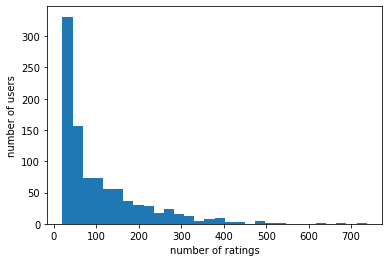

In [0]:
ratings = dataPreprocessor(rating_df, num_users, num_items)
num = []
for user in range(0,len(ratings)):
  count = 0
  for item in range(0,len(ratings[user])):
    if ratings[user][item] != 0:
      count += 1
  num.append(count)

plt.hist(num, bins=30)
plt.xlabel("number of ratings")
plt.ylabel("number of users")
plt.show()

Pick threshold = 40.

(i)Above 40 of liked items

High (User): 1.0191489463878776
High (Item): 1.0113305978925313

High (User): 1.0159271155620724
High (Item): 1.0190664527829598

High (User): 1.0112676777768064
High (Item): 1.0181470171783826

High (User): 1.0068579101716613
High (Item): 1.0133918930121206

High (User): 1.0116756933057802
High (Item): 1.0194927218846792

(ii)Below 40 of liked items

Low (User): 1.1558571570778884
Low (Item): 1.3713576937684786

Low (User): 1.2037370367126599
Low (Item): 1.2715746918449673

Low (User): 1.1494066631217454
Low (Item): 1.2800524007005154

Low (User): 1.1774999724475854
Low (Item): 1.3378080526697897

Low (User): 1.177729439932829
Low (Item): 1.3003463362468513

In both cases, user-user collaborative filtering performs better than  item-item collaborative filtering because of significantly more items than users in the dataset. However, the overall performance is better for criteria rating >40 items per users. This is because the number of users with more than or equal to 40 ratings is much more than the number of users with less than 40 ratings.


In [0]:
few_rating_df = rating_df.copy()
more_rating_df = rating_df.copy()

for userID in few_rating_df.userID.unique():
  if len(few_rating_df[few_rating_df['userID'] == userID]) >= 40:
    few_rating_df.drop(few_rating_df.loc[few_rating_df['userID']==userID].index, inplace=True)    
  else: more_rating_df.drop(few_rating_df.loc[few_rating_df['userID']==userID].index, inplace=True)


In [0]:
from sklearn.model_selection import KFold 
kf = KFold(n_splits=5, random_state=42, shuffle=True) 
kf.get_n_splits(few_rating_df) # returns the number of splitting iterations in the cross-validator

for train_index, test_index in kf.split(few_rating_df):
    train = few_rating_df.iloc[train_index]
    test =  few_rating_df.iloc[test_index]

    user_cosine_recsys = SimBasedRecSys('user','cosine')
    user_cosine_recsys.predict_all(train, num_users, num_items)
    user_cosine_recsys.getModel()
    userAvgPreiction = user_cosine_recsys.evaluate_test(test,copy=True)
    
    item_cosine_recsys = SimBasedRecSys('item','cosine')
    item_cosine_recsys.predict_all(train, num_users, num_items)
    item_cosine_recsys.getModel()
    itemAvgPreiction = item_cosine_recsys.evaluate_test(test,copy=True)

    print ('Low (User):',sqrt(mean_squared_error(userAvgPreiction['rating'], userAvgPreiction['user-cosine'])))
    print ('Low (Item):',sqrt(mean_squared_error(itemAvgPreiction['rating'], itemAvgPreiction['item-cosine'])))


0it [00:00, ?it/s]
198it [00:00, 1974.45it/s]
424it [00:00, 2051.26it/s]
650it [00:00, 2108.61it/s]
891it [00:00, 2188.72it/s]
1110it [00:00, 2187.59it/s]
1340it [00:00, 2218.26it/s]
1540it [00:00, 2085.75it/s]
1622it [00:00, 2147.65it/s]
0it [00:00, ?it/s]
188it [00:00, 1874.04it/s]
417it [00:00, 1980.87it/s]
655it [00:00, 2084.85it/s]
893it [00:00, 2164.81it/s]
1126it [00:00, 2210.87it/s]
1354it [00:00, 2229.76it/s]
1597it [00:00, 2285.06it/s]
1622it [00:00, 2251.47it/s]

Low (User): 1.1558571570778884
Low (Item): 1.3713576937684786



0it [00:00, ?it/s]
189it [00:00, 1883.21it/s]
424it [00:00, 2001.71it/s]
657it [00:00, 2088.85it/s]
897it [00:00, 2173.02it/s]
1127it [00:00, 2209.20it/s]
1368it [00:00, 2264.76it/s]
1595it [00:00, 2263.74it/s]
1622it [00:00, 2247.00it/s]
0it [00:00, ?it/s]
187it [00:00, 1862.77it/s]
405it [00:00, 1946.52it/s]
633it [00:00, 2034.45it/s]
865it [00:00, 2111.49it/s]
1109it [00:00, 2199.95it/s]
1348it [00:00, 2253.26it/s]
1575it [00:00, 2255.88it/s]
1622it [00:00, 2224.20it/s]

Low (User): 1.2037370367126599
Low (Item): 1.2715746918449673



0it [00:00, ?it/s]
187it [00:00, 1867.02it/s]
407it [00:00, 1955.16it/s]
635it [00:00, 2042.09it/s]
860it [00:00, 2098.58it/s]
1090it [00:00, 2154.42it/s]
1293it [00:00, 2113.21it/s]
1518it [00:00, 2152.01it/s]
1622it [00:00, 2152.44it/s]
0it [00:00, ?it/s]
190it [00:00, 1893.77it/s]
422it [00:00, 2003.68it/s]
640it [00:00, 2052.03it/s]
877it [00:00, 2136.71it/s]
1102it [00:00, 2168.96it/s]
1341it [00:00, 2229.29it/s]
1578it [00:00, 2268.57it/s]
1622it [00:00, 2230.54it/s]

Low (User): 1.1494066631217454
Low (Item): 1.2800524007005154



0it [00:00, ?it/s]
190it [00:00, 1893.67it/s]
435it [00:00, 2030.97it/s]
656it [00:00, 2079.96it/s]
890it [00:00, 2150.99it/s]
1122it [00:00, 2197.21it/s]
1363it [00:00, 2254.72it/s]
1606it [00:00, 2303.45it/s]
1622it [00:00, 2265.42it/s]
0it [00:00, ?it/s]
183it [00:00, 1829.84it/s]
405it [00:00, 1930.10it/s]
648it [00:00, 2056.88it/s]
890it [00:00, 2153.59it/s]
1124it [00:00, 2204.82it/s]
1359it [00:00, 2245.52it/s]
1577it [00:00, 2225.06it/s]
1622it [00:00, 2223.17it/s]

Low (User): 1.1774999724475854
Low (Item): 1.3378080526697897



0it [00:00, ?it/s]
184it [00:00, 1839.62it/s]
397it [00:00, 1916.86it/s]
621it [00:00, 2002.01it/s]
843it [00:00, 2061.87it/s]
1078it [00:00, 2139.76it/s]
1310it [00:00, 2190.18it/s]
1552it [00:00, 2250.34it/s]
1622it [00:00, 2190.16it/s]
0it [00:00, ?it/s]
148it [00:00, 1477.50it/s]
358it [00:00, 1620.56it/s]
587it [00:00, 1775.87it/s]
827it [00:00, 1925.53it/s]
1057it [00:00, 2024.21it/s]
1293it [00:00, 2114.36it/s]
1519it [00:00, 2155.68it/s]
1622it [00:00, 2152.65it/s]

Low (User): 1.177729439932829
Low (Item): 1.3003463362468513


In [0]:
kf = KFold(n_splits=5, random_state=42, shuffle=True) # Define the split - into 10 folds 
kf.get_n_splits(more_rating_df) # returns the number of splitting iterations in the cross-validator

for train_index, test_index in kf.split(more_rating_df):
    train = more_rating_df.iloc[train_index]
    test =  more_rating_df.iloc[test_index]

    user_cosine_recsys = SimBasedRecSys('user','cosine')
    user_cosine_recsys.predict_all(train, num_users, num_items)
    user_cosine_recsys.getModel()
    userAvgPreiction = user_cosine_recsys.evaluate_test(test,copy=True)
    
    item_cosine_recsys = SimBasedRecSys('item','cosine')
    item_cosine_recsys.predict_all(train, num_users, num_items)
    item_cosine_recsys.getModel()
    itemAvgPreiction = item_cosine_recsys.evaluate_test(test,copy=True)

    print ('High (User):',sqrt(mean_squared_error(userAvgPreiction['rating'], userAvgPreiction['user-cosine'])))
    print ('High (Item):',sqrt(mean_squared_error(itemAvgPreiction['rating'], itemAvgPreiction['item-cosine'])))

18378it [00:08, 2109.85it/s]
18378it [00:08, 2113.31it/s]


High (User): 1.0191489463878776
High (Item): 1.0113305978925313


18378it [00:08, 2124.99it/s]
18378it [00:08, 2144.36it/s]


High (User): 1.0159271155620724
High (Item): 1.0190664527829598


18378it [00:08, 2122.56it/s]
18378it [00:08, 2118.27it/s]


High (User): 1.0112676777768064
High (Item): 1.0181470171783826


18378it [00:08, 2119.45it/s]
18378it [00:08, 2096.58it/s]


High (User): 1.0068579101716613
High (Item): 1.0133918930121206


18378it [00:08, 2115.26it/s]
18378it [00:08, 2135.80it/s]

High (User): 1.0116756933057802
High (Item): 1.0194927218846792
